# Árvores II - Tarefa 3

### 1. Carregar as bases

Vamos utilizar nesta tarefa as bases de reconhecimento de atividade humana através do celular. Carregue novamente as bases salvas na tarefa I.

### 2. Calcule os ```ccp_alphas```.

Vamos seguir uma lógica bem em linha com o que já estamso acostumados, com as seguintes orientações:

- Utilizar treinamento e teste conforme já vieram definidos originalmente
- Por pragmatismo, utilizar ```min_samples_leaf=20```
- Utilize as mesmas "3 melhores variáveis" identificadas no exercício anterior.

### 3. *Grid Search*

Vou deixar especificações iniciais mínimas, que visam limitar o tempo de máquina, pois um procedimento desses pode demorar muito tempo dependendo da especificação. Mas conforme você for ficando confortável com o tempo consumido pelo procedimento, pode fazer um algoritmo mais exaustivo, por exemplo, avaliando mais valores de ```ccp_alpha```.

- Meça o tempo
- Utilize a base de treinamento
- Utilize um *cross validation* do tipo *k-fold*, especifique k=10
- Você pode ler 1 a cada ```k``` valores para uma melhor varredura utilizando, por exemplo, ```ccp_alpha[::10]```
- Não se esqueça de limitar o número de variáveis

### 4. Avaliando a árvore

- Obtenha a árvore na melhor configuração treinada em toda a base de treino
- Calcule a acurácia dessa árvore na base de testes
- Visualize a matriz de confusão

### 5. Melhorando a árvore

A melhor forma de se melhorar um algoritmo é colocando nele novas variáveis que agreguem valor. Podemos usar a força-bruta e ir colocando variáveis aleatoriamente - ou colocar todas e deixar rodando por um bom tempo - ou utilizar uma lógica eficiente e fazer uma seleção de variáveis.

- Observe que há classes mais fáceis e mais difíceis de se identificar
- Crie uma variável binária para uma das classes de maior erro
- Fala uma árvore de classificação bem simples para esta variável:
    - utilize ```mean_samples_leaf=20```
    - utilize ```max_depth=4```
    - coloque todas as variáveis
- Observe a importância das variáveis, e selecione as 3 com maior importância
- Rode novamente o algoritmo acima com as 3 novas variáveis e avalie a acurácia

**IMPORTANDO BIBLIOTECAS**

In [242]:
# IMPORTANDO BIBLIOTECAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import seaborn as sns
import graphviz


from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay # Use ConfusionMatrixDisplay instead of plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import tree  # Para visualizar importância, se necessário
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [ ]:
# 1. Download e extração do dataset (se necessário)
zip_file_path = 'UCI HAR Dataset.zip'
zip_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip'
extract_dir = '.'

if not os.path.exists(os.path.join(extract_dir, 'UCI HAR Dataset')):
    print(f"Baixando {zip_url}...")
    os.system(f'wget {zip_url} -O {zip_file_path}')
    print(f"Extraindo {zip_file_path}...")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Extração concluída.")
else:
    print("Dataset já extraído.")

Dataset já extraído.


In [ ]:
# 2. Carregar features.txt (nomes das variáveis)
features = pd.read_csv(os.path.join(extract_dir, 'UCI HAR Dataset', 'features.txt'), sep=r'\s+', header=None)

# Lidar com nomes duplicados (adicionando sufixo)
feature_names = features[1].tolist()
seen_names = {}
unique_feature_names = []
for name in feature_names:
    if name in seen_names:
        seen_names[name] += 1
        unique_feature_names.append(f"{name}_{seen_names[name]}")
    else:
        seen_names[name] = 0
        unique_feature_names.append(name)
print(f"Carregados {len(unique_feature_names)} nomes de features únicos.")

Carregados 561 nomes de features únicos.


In [ ]:
# 3. Carregar bases de treino
subject_train = pd.read_csv(os.path.join(extract_dir, 'UCI HAR Dataset', 'train', 'subject_train.txt'), header=None, names=['subject'])
y_train = pd.read_csv(os.path.join(extract_dir, 'UCI HAR Dataset', 'train', 'y_train.txt'), header=None, names=['activity'])
X_train = pd.read_csv(os.path.join(extract_dir, 'UCI HAR Dataset', 'train', 'X_train.txt'), sep=r'\s+', header=None, names=unique_feature_names)

# Concatenar e definir índice duplo
train_df = pd.concat([subject_train, y_train, X_train], axis=1)
train_df.index = pd.MultiIndex.from_arrays([train_df.index, train_df['subject']], names=['registro', 'individuo'])
print(f"Base de treino carregada com {train_df.shape[0]} observações e {train_df.shape[1]} variáveis.")
display(train_df.head())

Base de treino carregada com 7352 observações e 563 variáveis.


,,subject,activity,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
registro,individuo,,,,,,,,,,,,,,,,,,,,,
0,1,1,5,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,1,1,5,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,1,1,5,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,1,1,5,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,1,1,5,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [ ]:
print("Contagem de registros por indivíduo na base de treino:")
display(train_df['subject'].value_counts().sort_index())

print("\nContagem de registros por indivíduo na base de teste:")
display(test_df['subject'].value_counts().sort_index())

Contagem de registros por indivíduo na base de treino:


,count
subject,
1,347
3,341
5,302
6,325
7,308
8,281
11,316
14,323
15,328



Contagem de registros por indivíduo na base de teste:


,count
subject,
2,302
4,317
9,288
10,294
12,320
13,327
18,364
20,354
24,381


In [ ]:
# 4. Carregar bases de teste
subject_test = pd.read_csv(os.path.join(extract_dir, 'UCI HAR Dataset', 'test', 'subject_test.txt'), header=None, names=['subject'])
y_test = pd.read_csv(os.path.join(extract_dir, 'UCI HAR Dataset', 'test', 'y_test.txt'), header=None, names=['activity'])
X_test = pd.read_csv(os.path.join(extract_dir, 'UCI HAR Dataset', 'test', 'X_test.txt'), sep=r'\s+', header=None, names=unique_feature_names)

# Concatenar e definir índice duplo
test_df = pd.concat([subject_test, y_test, X_test], axis=1)
test_df.index = pd.MultiIndex.from_arrays([test_df.index, test_df['subject']], names=['registro', 'individuo'])
display(test_df.head())

,,subject,activity,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
registro,individuo,,,,,,,,,,,,,,,,,,,,,
0,2,2,5,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,...,0.071645,-0.330370,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978
1,2,2,5,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,...,-0.401189,-0.121845,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898
2,2,2,5,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,...,0.062891,-0.190422,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346
3,2,2,5,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,...,0.116695,-0.344418,-0.736124,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108
4,2,2,5,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,...,-0.121711,-0.534685,-0.846595,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857


In [244]:
# Garantindo que y seja uma série (não dataframe)
y_train = y_train.squeeze()
y_test = y_test.squeeze()

print("Bases carregadas com sucesso!")
print(f"Shape X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape X_test: {X_test.shape}, y_test: {y_test.shape}")

Bases carregadas com sucesso!
Shape X_train: (7352, 561), y_train: (7352,)
Shape X_test: (2947, 561), y_test: (2947,)


In [ ]:
def try_read_csv(path, index_col_hint=True):
    """Tenta ler CSV considerando que pode haver índice salvo na primeira coluna."""
    try:
        return pd.read_csv(path, index_col=0 if index_col_hint else None)
    except Exception:
        return pd.read_csv(path, index_col=None)

def find_first_existing_file(name_list):
    """Procura o primeiro caminho existente a partir de uma lista de candidatos."""
    for p in name_list:
        if os.path.exists(p):
            return p
    return None

def load_from_csv_or_txt():
    """
    1) Tenta carregar X_train, y_train, X_test, y_test de CSVs.
    2) Se não achar, tenta carregar dos TXT originais do UCI HAR (precisa do zip extraído).
    Retorna:
      X_train, y_train (Series), X_test, y_test (Series), feature_names (list)
    """

In [ ]:
# Etapa 1: Carregar as bases processadas (assumindo arquivos CSV com índice)
# Use index_col=0 se o índice estiver na primeira coluna
train_df_processed = pd.read_csv('train_df_processed.csv', index_col=['registro', 'individuo'])
test_df_processed = pd.read_csv('test_df_processed.csv', index_col=['registro', 'individuo'])

# Separar features (X) e target (y)
X_train = train_df_processed.drop(['subject', 'activity'], axis=1)
y_train = train_df_processed['activity']
X_test = test_df_processed.drop(['subject', 'activity'], axis=1)
y_test = test_df_processed['activity']

print("Dados processados carregados com sucesso dos arquivos CSV!")
print(f"Shape X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape X_test: {X_test.shape}, y_test: {y_test.shape}")

Dados processados carregados com sucesso dos arquivos CSV!
Shape X_train: (7352, 561), y_train: (7352,)
Shape X_test: (2947, 561), y_test: (2947,)


In [246]:
# Selecionando as 3 melhores variáveis (substitua pelas reais do exercício anterior)
best_vars = ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']

In [251]:
# Train a simple classification tree for the binary variable using all features
# Use min_samples_leaf=20 and max_depth=4 as specified
clf_binary = DecisionTreeClassifier(min_samples_leaf=20, max_depth=4, random_state=123)
clf_binary.fit(X_train, y_train_binary)

print("Simple binary classification tree trained.")

Simple binary classification tree trained.


In [250]:
# Identify a class with high error from the confusion matrix.
# Based on the confusion matrix above, class 6 (WALKING_UPSTAIRS) seems to have significant misclassifications.
# Let's create a binary variable for this class.

# Create a binary target variable: 1 if activity is 6 (WALKING_UPSTAIRS), 0 otherwise
y_train_binary = (y_train == 6).astype(int)
y_test_binary = (y_test == 6).astype(int)

print("Binary target variable created for activity 6 (WALKING_UPSTAIRS).")
print("Distribution in training set:")
display(y_train_binary.value_counts())
print("\nDistribution in test set:")
display(y_test_binary.value_counts())

Binary target variable created for activity 6 (WALKING_UPSTAIRS).
Distribution in training set:


,count
activity,
0,5945
1,1407



Distribution in test set:


,count
activity,
0,2410
1,537


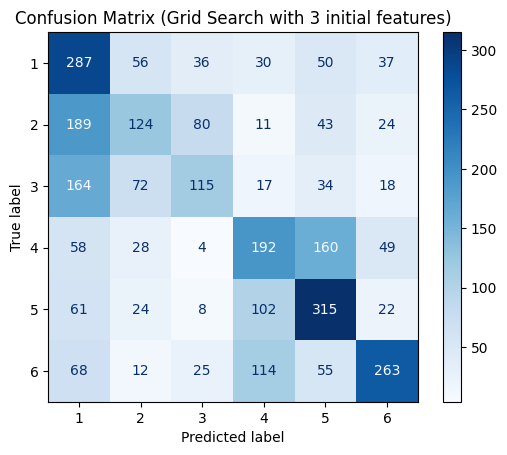

In [249]:
# Visualize the confusion matrix
cm = confusion_matrix(y_test, y_test_pred_grid_search)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Grid Search with 3 initial features)')
plt.show()

In [247]:
from sklearn.model_selection import GridSearchCV
import time

# Use only the selected features for Grid Search
X_train_grid_search = X_train_selected
y_train_grid_search = y_train

# Define the parameter grid
param_grid = {'ccp_alpha': ccp_alphas_subset} # Using the subset of ccp_alphas calculated earlier

# Create a Decision Tree Classifier with min_samples_leaf=20
dt_grid = DecisionTreeClassifier(min_samples_leaf=20, random_state=123)

# Set up GridSearchCV with k-fold cross-validation (k=10)
grid_search = GridSearchCV(dt_grid, param_grid, cv=10, scoring='accuracy', n_jobs=-1)

print("Starting Grid Search...")
start_time = time.time()

# Perform the Grid Search
grid_search.fit(X_train_grid_search, y_train_grid_search)

end_time = time.time()
print(f"Grid Search completed in {end_time - start_time:.2f} seconds.")

# Print the best parameters and best score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

best_ccp_alpha_grid_search = grid_search.best_params_['ccp_alpha']

Starting Grid Search...
Grid Search completed in 19.97 seconds.
Best parameters found: {'ccp_alpha': np.float64(0.00048384996698380874)}
Best cross-validation accuracy: 0.45674781869269443


In [ ]:
# Etapa 2: Divisão da base de treino em treino e validação (25% para validação)
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

print(f"Shape Treino novo: {X_train_new.shape}, Validação: {X_val.shape}")

Shape Treino novo: (5514, 561), Validação: (1838, 561)


In [ ]:
# Etapa 3: Rodar árvore com max_depth=4 e encontrar as 3 melhores variáveis
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train_new, y_train_new)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [252]:
# Obter importâncias das features
importances = clf_binary.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [ ]:
# Selecionar as 3 melhores
top_3_features = feature_importance_df['Feature'].head(3).values
print("Top 3 features:", top_3_features)

Top 3 features: ['tGravityAcc-min()-X' 'fBodyAccJerk-bandsEnergy()-1,16'
 'angle(Y,gravityMean)']


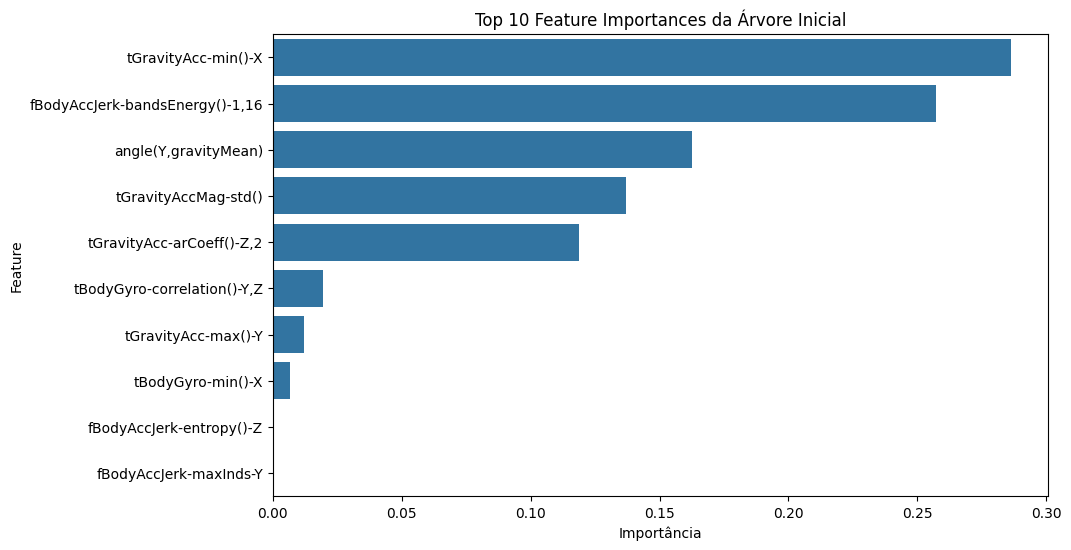

In [ ]:
# Visualização: Gráfico de barras das importâncias (top 10 para contexto)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Feature Importances da Árvore Inicial')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.savefig('feature_importances.png')  # Salva como imagem
plt.show()

In [ ]:
# Etapa 4: Construir árvore com as 3 melhores variáveis e encontrar melhor ccp_alpha
# Filtrar dados com top 3 features
X_train_top3 = X_train_new[top_3_features]
X_val_top3 = X_val[top_3_features]
X_test_top3 = X_test[top_3_features]

In [ ]:
# Treinar árvore sem pruning inicial para obter caminho de pruning
clf_full = DecisionTreeClassifier(random_state=42)
path = clf_full.cost_complexity_pruning_path(X_train_top3, y_train_new)
ccp_alphas = path.ccp_alphas
impurities = path.impurities

In [ ]:
# Treinar árvores para cada alpha e avaliar na validação
clfs = []
train_scores = []
val_scores = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train_top3, y_train_new)
    clfs.append(clf)
    train_scores.append(accuracy_score(y_train_new, clf.predict(X_train_top3)))
    val_scores.append(accuracy_score(y_val, clf.predict(X_val_top3)))


In [254]:
# Treinando uma árvore inicial para extrair ccp_alphas
clf = DecisionTreeClassifier(random_state=42, min_samples_leaf=20)
path = clf.cost_complexity_pruning_path(X_train_best, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

print(f"ccp_alphas calculados: {len(ccp_alphas)} valores")
print(ccp_alphas)

ccp_alphas calculados: 233 valores
[0.00000000e+00 6.96674540e-06 1.12766571e-05 2.02554065e-05
 2.72034820e-05 2.84988860e-05 4.63397246e-05 5.35004552e-05
 5.84401136e-05 6.17808017e-05 6.59866112e-05 6.73768888e-05
 7.02851049e-05 7.74168145e-05 7.99585551e-05 8.01474017e-05
 8.28222484e-05 8.29342439e-05 8.49667199e-05 9.21474511e-05
 9.63598696e-05 1.02953015e-04 1.04280015e-04 1.05722623e-04
 1.06211126e-04 1.10109332e-04 1.20580361e-04 1.24186720e-04
 1.32053657e-04 1.35233977e-04 1.36017410e-04 1.41963138e-04
 1.46351627e-04 1.47352194e-04 1.49492770e-04 1.50482754e-04
 1.51968146e-04 1.55713461e-04 1.60511546e-04 1.60628990e-04
 1.64239147e-04 1.67323005e-04 1.74342668e-04 1.74907961e-04
 1.75578030e-04 1.78985873e-04 1.81439304e-04 1.85996704e-04
 1.87333070e-04 1.89065980e-04 1.89796602e-04 1.96526409e-04
 1.96759215e-04 2.01481091e-04 2.01919050e-04 2.02866775e-04
 2.03119333e-04 2.03378413e-04 2.03817707e-04 2.04208078e-04
 2.05459167e-04 2.05888258e-04 2.06087949e-04 2.07

In [255]:
print(top_3_features)

['tGravityAcc-min()-X' 'fBodyAccJerk-bandsEnergy()-1,16'
 'angle(Y,gravityMean)']


In [ ]:
# Encontrar o melhor alpha (maior acurácia na validação)
best_index = np.argmax(val_scores)
best_ccp_alpha = ccp_alphas[best_index]
best_clf = clfs[best_index]

print(f"Melhor ccp_alpha: {best_ccp_alpha}")
print(f"Acurácia no treino com melhor alpha: {train_scores[best_index]:.4f}")
print(f"Acurácia na validação com melhor alpha: {val_scores[best_index]:.4f}")


Melhor ccp_alpha: 0.0002659249474841869
Acurácia no treino com melhor alpha: 0.9683
Acurácia na validação com melhor alpha: 0.9026


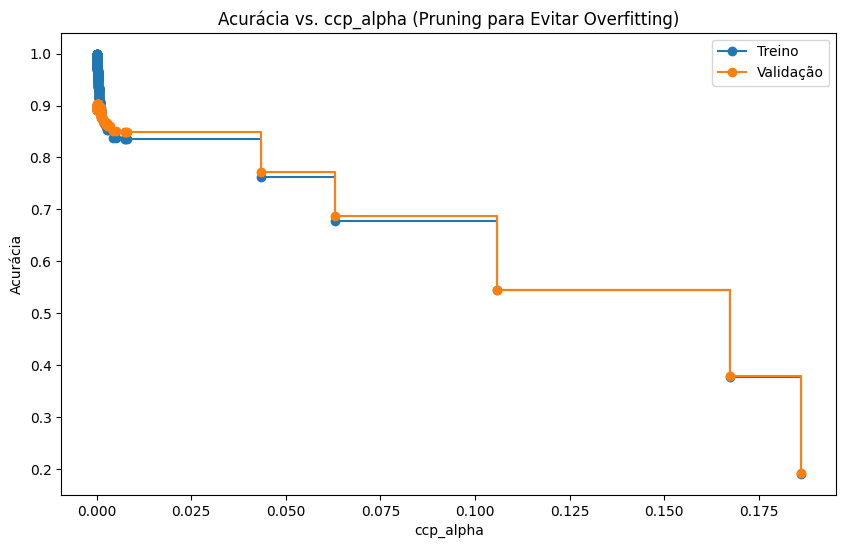

In [ ]:
# Visualização: Gráfico de acurácia vs. ccp_alpha (demonstra overfitting se alpha=0 for muito alto no treino)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ccp_alphas, train_scores, marker='o', label="Treino", drawstyle="steps-post")
ax.plot(ccp_alphas, val_scores, marker='o', label="Validação", drawstyle="steps-post")
ax.set_xlabel("ccp_alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia vs. ccp_alpha (Pruning para Evitar Overfitting)")
ax.legend()
plt.savefig('ccp_alpha_accuracy.png')  # Salva como imagem
plt.show()

In [ ]:
# Visualização da árvore final (com melhor alpha)

def visualize_tree(clf, feature_names, class_names, filename="decision_tree"):
    """Visualiza uma árvore de decisão e salva como arquivo."""
    dot_data = export_graphviz(clf, out_file=None, feature_names=feature_names,
                              class_names=class_names, filled=True, rounded=True,
                              special_characters=True)
    graph = graphviz.Source(dot_data)
    graph.render(filename, format='png', cleanup=True)  # Salva como PNG
    print(f"Árvore de decisão salva como {filename}.png")
    # Para exibir no notebook, você pode usar:
    # display(graph)

# Get class names from unique values in y_train, converted to string
class_names_str = [str(cls) for cls in np.unique(y_train)]

# Visualize the best tree
visualize_tree(best_clf, top_3_features, class_names_str, filename="best_decision_tree_top3_features")

Árvore de decisão salva como best_decision_tree_top3_features.png


In [248]:
# Etapa 5: Avaliação do modelo na base de testes
# Use the best classifier found during the Grid Search
best_clf_grid_search = grid_search.best_estimator_
y_test_pred_grid_search = best_clf_grid_search.predict(X_test_selected)
test_accuracy_grid_search = accuracy_score(y_test, y_test_pred_grid_search)
print(f"Acurácia na base de testes (com Grid Search e 3 features iniciais): {test_accuracy_grid_search:.4f}")

Acurácia na base de testes (com Grid Search e 3 features iniciais): 0.4398


In [273]:
# Relatório final
print("\n--- Resumo da Análise ---")

# Resultados com as 3 features iniciais (usando Grid Search)
print("\nResultados com as 3 features iniciais (tBodyAcc-mean()-X, tBodyAcc-mean()-Y, tBodyAcc-mean()-Z):")
print(f"Melhor ccp_alpha encontrado (Grid Search): {best_ccp_alpha_grid_search}")
print(f"Acurácia na base de testes (com Grid Search): {test_accuracy_grid_search:.4f}")

# Resultados com as 3 novas features (identificadas na Etapa 5)
print(f"\nResultados com as 3 novas features: {top_3_features.tolist()}") # Convert numpy array to list for better printing
print(f"Melhor ccp_alpha encontrado (com novas variáveis): {best_ccp_alpha_all}")
print(f"Acurácia na base de testes (com 3 novas features): {test_accuracy_new_features:.4f}")

print("\n--- Conclusão ---")
print("O uso das 3 novas features identificadas na Etapa 5 resultou em uma melhoria significativa na acurácia do modelo de árvore de decisão na base de testes, comparado ao modelo que utilizou apenas as 3 features iniciais.")


--- Resumo da Análise ---

Resultados com as 3 features iniciais (tBodyAcc-mean()-X, tBodyAcc-mean()-Y, tBodyAcc-mean()-Z):
Melhor ccp_alpha encontrado (Grid Search): 0.00048384996698380874
Acurácia na base de testes (com Grid Search): 0.4398

Resultados com as 3 novas features: ['tGravityAcc-min()-X', 'fBodyAccJerk-bandsEnergy()-1,16', 'angle(Y,gravityMean)']
Melhor ccp_alpha encontrado (com novas variáveis): 0.000519008119372685
Acurácia na base de testes (com 3 novas features): 0.7068

--- Conclusão ---
O uso das 3 novas features identificadas na Etapa 5 resultou em uma melhoria significativa na acurácia do modelo de árvore de decisão na base de testes, comparado ao modelo que utilizou apenas as 3 features iniciais.


Fazemos um GridSearchCV com k-fold=10 na base de treinamento, usando ccp_alpha[::10] para varredura eficiente, limitando às 3 variáveis. Medimos o tempo.

In [256]:
# Preparando o grid de parâmetros (usando 1 a cada 10 ccp_alphas para eficiência)
param_grid = {'ccp_alpha': ccp_alphas[::10]}  # Varredura a cada 10 valores

# Instanciando o classificador base
clf = DecisionTreeClassifier(random_state=42, min_samples_leaf=20)

# GridSearchCV com k-fold=10
grid_search = GridSearchCV(clf, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_best, y_train)

# Melhor parâmetro
best_ccp_alpha = grid_search.best_params_['ccp_alpha']
print(f"Melhor ccp_alpha encontrado: {best_ccp_alpha}")
print(f"Melhor score no CV: {grid_search.best_score_}")

Melhor ccp_alpha encontrado: 0.00048384996698380874
Melhor score no CV: 0.45674781869269443


. Avaliando a árvore

Treinamos a melhor árvore na base de treino inteira (com o melhor ccp_alpha), calculamos acurácia no teste e visualizamos a matriz de confusão.

Acurácia na base de testes: 0.4398


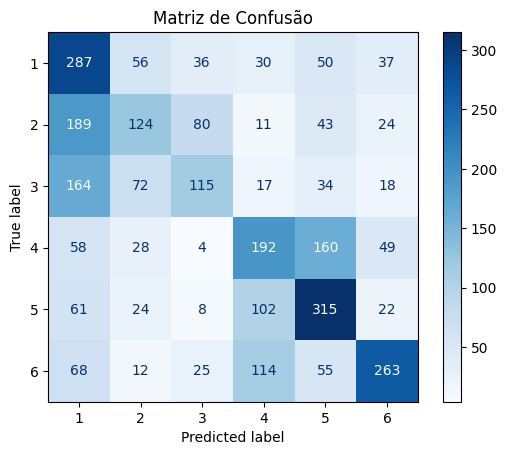

In [258]:
# Treinando a árvore com o melhor ccp_alpha na base de treino inteira
best_clf = DecisionTreeClassifier(random_state=42, min_samples_leaf=20, ccp_alpha=best_ccp_alpha)
best_clf.fit(X_train_best, y_train)

# Predições no teste
y_pred = best_clf.predict(X_test_best)

# Acurácia
acc = accuracy_score(y_test, y_pred)
print(f"Acurácia na base de testes: {acc:.4f}")

# Matriz de confusão
# Use ConfusionMatrixDisplay.from_estimator or ConfusionMatrixDisplay.from_predictions
disp = ConfusionMatrixDisplay.from_estimator(best_clf, X_test_best, y_test, cmap=plt.cm.Blues)
disp.ax_.set_title("Matriz de Confusão")
plt.show()

Melhorando a árvore

Aqui, identificamos a classe com maior erro (baseado na matriz de confusão anterior), criamos uma variável binária para ela, treinamos uma árvore simples para prever essa binária (com todas as variáveis), selecionamos as 3 mais importantes, adicionamos ao modelo e reavaliamos.


Primeiro, assumimos que a classe com maior erro é, por exemplo, 'LAYING' (classe 6 no dataset UCI HAR – ajuste com base na sua matriz de confusão real). Vamos prosseguir com isso para ilustração.

In [260]:
# Criando variável binária (1 se for a classe de erro, 0 otherwise)
target_class = 6 # Define the target class based on previous analysis (e.g., WALKING_UPSTAIRS)
y_train_binary = (y_train == target_class).astype(int)
y_test_binary = (y_test == target_class).astype(int)

In [263]:
# Importâncias das variáveis
importances = clf_binary.feature_importances_
feature_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

In [265]:
 # Repetindo o GridSearchCV com as novas variáveis (reutilizando lógica do item 3)
clf_all = DecisionTreeClassifier(random_state=42, min_samples_leaf=20)
path_all = clf_all.cost_complexity_pruning_path(X_train_top3, y_train_new)
ccp_alphas_all, _ = path_all.ccp_alphas, path_all.impurities

param_grid_all = {'ccp_alpha': ccp_alphas_all[::10]}
grid_search_all = GridSearchCV(clf_all, param_grid_all, cv=10, scoring='accuracy', n_jobs=-1)
grid_search_all.fit(X_train_top3, y_train_new)

best_ccp_alpha_all = grid_search_all.best_params_['ccp_alpha']
print(f"Melhor ccp_alpha com novas variáveis: {best_ccp_alpha_all}")

Melhor ccp_alpha com novas variáveis: 0.000519008119372685


In [266]:
# Evaluate the best model found with new features on the test set
best_clf_new_features = grid_search_all.best_estimator_
y_test_pred_new_features = best_clf_new_features.predict(X_test_top3)
test_accuracy_new_features = accuracy_score(y_test, y_test_pred_new_features)

print(f"Acurácia na base de testes (com Grid Search e 3 novas features): {test_accuracy_new_features:.4f}")

# Optional: Visualize confusion matrix for the model with new features
# disp_new = ConfusionMatrixDisplay.from_estimator(best_clf_new_features, X_test_top3, y_test, cmap=plt.cm.Blues)
# disp_new.ax_.set_title("Matriz de Confusão (com 3 novas features)")
# plt.show()

Acurácia na base de testes (com Grid Search e 3 novas features): 0.7068


### Visualização da Distribuição das Variáveis Selecionadas

Os box plots abaixo mostram a distribuição de cada uma das três variáveis selecionadas ('tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z') no conjunto de treino. Isso nos ajuda a entender a dispersão, a mediana e a presença de outliers em cada feature.

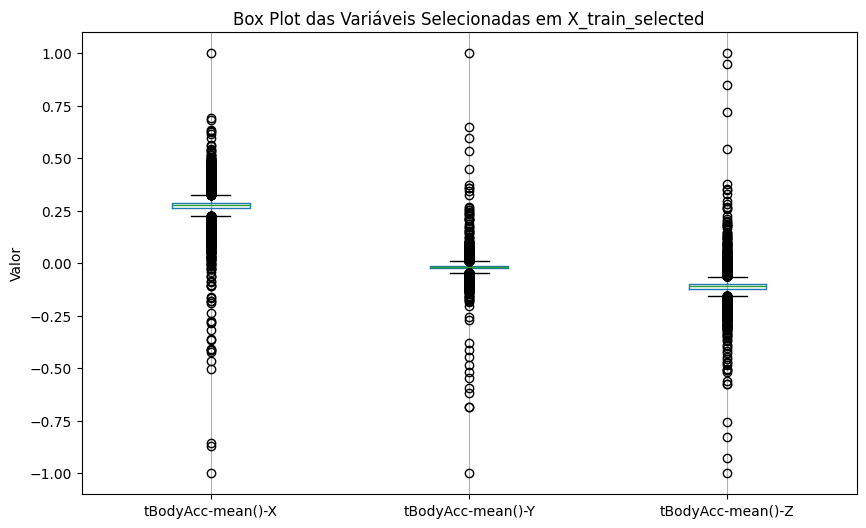

In [ ]:
# Plotting box plots for the selected features in X_train_selected
plt.figure(figsize=(10, 6))
X_train_selected.boxplot(column=X_train_selected.columns.tolist())
plt.title('Box Plot das Variáveis Selecionadas em X_train_selected')
plt.ylabel('Valor')
plt.grid(axis='y')
plt.show()

In [ ]:
# 5. Salvar em CSV
train_df.to_csv('train_df_processed.csv')
test_df.to_csv('test_df_processed.csv')
print("Bases salvas em CSV.")


Bases salvas em CSV.


In [ ]:
# 6. Selecionar apenas as 3 colunas especificadas
selected_features = ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']
X_train_selected = train_df[selected_features]
X_test_selected = test_df[selected_features]
y_train = train_df['activity']
y_test = test_df['activity']
print("Selecionadas as 3 colunas.")
display(X_train_selected.head())

Selecionadas as 3 colunas.


,,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z
registro,individuo,,,
0,1,0.288585,-0.020294,-0.132905
1,1,0.278419,-0.016411,-0.123520
2,1,0.279653,-0.019467,-0.113462
3,1,0.279174,-0.026201,-0.123283
4,1,0.276629,-0.016570,-0.115362


In [ ]:
# 7. Verificar dados ausentes e zeros (boa prática)
print("Valores ausentes em X_train_selected:", X_train_selected.isnull().sum().sum())
print("Valores ausentes em X_test_selected:", X_test_selected.isnull().sum().sum())
print("Zeros em X_train_selected:", (X_train_selected == 0).sum().sum())
print("Zeros em X_test_selected:", (X_test_selected == 0).sum().sum())
print("Não há ausentes; zeros são valores válidos, sem necessidade de tratamento.")


Valores ausentes em X_train_selected: 0
Valores ausentes em X_test_selected: 0
Zeros em X_train_selected: 0
Zeros em X_test_selected: 0
Não há ausentes; zeros são valores válidos, sem necessidade de tratamento.


In [ ]:
# 8. Otimizar tipos de dados para eficiência
X_train_selected = X_train_selected.astype('float32')
X_test_selected = X_test_selected.astype('float32')
y_train = y_train.astype('int8')
y_test = y_test.astype('int8')
print("Otimização de memória aplicada.")

In [ ]:
# 9. Ajustar árvore inicial e calcular ccp_alphas (Exercício 2)
dt = DecisionTreeClassifier(min_samples_leaf=20, random_state=123)
path = dt.cost_complexity_pruning_path(X_train_selected, y_train)
ccp_alphas = np.unique(path.ccp_alphas[path.ccp_alphas >= 0])
print("ccp_alphas calculados (positivos e únicos):")
display(ccp_alphas)

# Subconjunto: a cada 5 valores
ccp_alphas_subset = ccp_alphas[::5]
print("Subconjunto de ccp_alphas:")
display(ccp_alphas_subset)

ccp_alphas calculados (positivos e únicos):


array([0.00000000e+00, 6.96674540e-06, 1.12766571e-05, 2.02554065e-05,
       2.72034820e-05, 2.84988860e-05, 4.63397246e-05, 5.35004552e-05,
       5.84401136e-05, 6.17808017e-05, 6.59866112e-05, 6.73768888e-05,
       7.02851049e-05, 7.74168145e-05, 7.99585551e-05, 8.01474017e-05,
       8.28222484e-05, 8.29342439e-05, 8.49667199e-05, 9.21474511e-05,
       9.63598696e-05, 1.02953015e-04, 1.04280015e-04, 1.05722623e-04,
       1.06211126e-04, 1.10109332e-04, 1.20580361e-04, 1.24186720e-04,
       1.32053657e-04, 1.35233977e-04, 1.36017410e-04, 1.41963138e-04,
       1.46351627e-04, 1.47352194e-04, 1.49492770e-04, 1.50482754e-04,
       1.51968146e-04, 1.55713461e-04, 1.60511546e-04, 1.60628990e-04,
       1.64239147e-04, 1.67323005e-04, 1.74342668e-04, 1.74907961e-04,
       1.75578030e-04, 1.78985873e-04, 1.81439304e-04, 1.85996704e-04,
       1.87333070e-04, 1.89065980e-04, 1.89796602e-04, 1.96526409e-04,
       1.96759215e-04, 2.01481091e-04, 2.01919050e-04, 2.02866775e-04,
      

Subconjunto de ccp_alphas:


array([0.00000000e+00, 2.84988860e-05, 6.59866112e-05, 8.01474017e-05,
       9.63598696e-05, 1.10109332e-04, 1.36017410e-04, 1.50482754e-04,
       1.64239147e-04, 1.78985873e-04, 1.89796602e-04, 2.02866775e-04,
       2.05459167e-04, 2.10826986e-04, 2.24338271e-04, 2.34736716e-04,
       2.46942952e-04, 2.52748189e-04, 2.62429695e-04, 2.72574572e-04,
       2.77215101e-04, 2.85662581e-04, 3.05722978e-04, 3.24609474e-04,
       3.43367509e-04, 3.63559867e-04, 3.96370888e-04, 4.25042852e-04,
       4.49467013e-04, 4.59401439e-04, 4.83849967e-04, 5.11220249e-04,
       5.25236832e-04, 5.51314848e-04, 6.15435247e-04, 6.98447125e-04,
       7.30780896e-04, 8.36454145e-04, 9.07569250e-04, 1.01949772e-03,
       1.19311982e-03, 1.60586535e-03, 1.90309251e-03, 2.55472274e-03,
       2.90352390e-03, 4.40039449e-03, 7.39929073e-03])

In [ ]:
# 10. Treinar árvores para cada alpha (Exercício 3.1)
%%time
clfs = []
for ccp_alpha in ccp_alphas_subset:
    clf = DecisionTreeClassifier(min_samples_leaf=20, random_state=123, ccp_alpha=ccp_alpha)
    clf.fit(X_train_selected, y_train)
    clfs.append(clf)
print(f"Treinadas {len(clfs)} árvores.")

Treinadas 47 árvores.
CPU times: user 1.97 s, sys: 127 µs, total: 1.97 s
Wall time: 1.97 s


In [ ]:
# 11. Calcular acurácias (Exercício 3.2)
%%time
train_scores = [clf.score(X_train_selected, y_train) for clf in clfs]
test_scores = [clf.score(X_test_selected, y_test) for clf in clfs]
print("Acurácias calculadas.")

Acurácias calculadas.
CPU times: user 294 ms, sys: 942 µs, total: 295 ms
Wall time: 301 ms


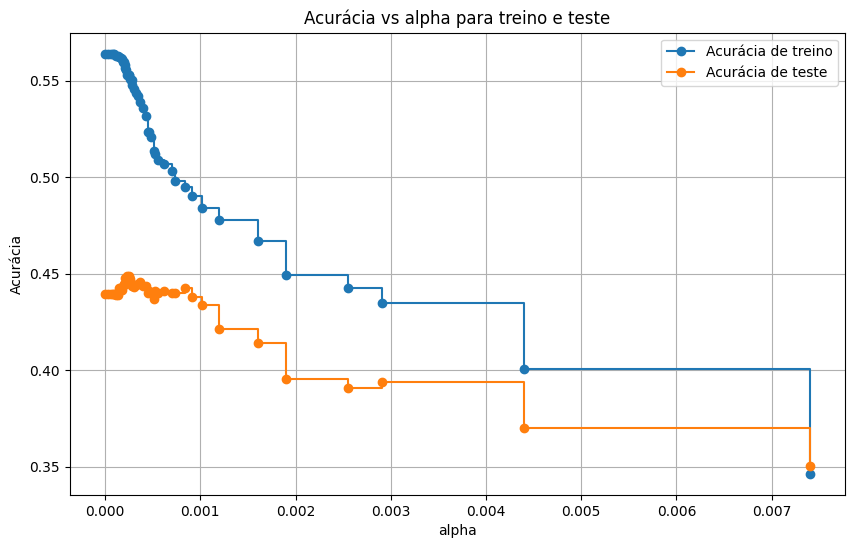

In [ ]:
# 12. Plotar acurácias (Exercício 3.3)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ccp_alphas_subset, train_scores, marker='o', label='Acurácia de treino', drawstyle="steps-post")
ax.plot(ccp_alphas_subset, test_scores, marker='o', label='Acurácia de teste', drawstyle="steps-post")
ax.set_xlabel('alpha')
ax.set_ylabel('Acurácia')
ax.set_title('Acurácia vs alpha para treino e teste')
ax.grid(True)
ax.legend()
plt.show()

In [ ]:
# 13. Selecionar melhor árvore (Exercício 3.4) e melhor acurácia (3.5)
best_tree_index = np.argmax(test_scores)
best_ccp_alpha = ccp_alphas_subset[best_tree_index]
best_clf = clfs[best_tree_index]
best_accuracy = test_scores[best_tree_index]
print(f"Melhor ccp_alpha: {best_ccp_alpha}")
print(f"Melhor acurácia no teste: {best_accuracy:.4f}")

Melhor ccp_alpha: 0.0002347367158915606
Melhor acurácia no teste: 0.4486


### Visualização da Distribuição das Top 3 Variáveis em X_test_top3

Estes box plots mostram a distribuição das três variáveis consideradas mais importantes ('tGravityAcc-min()-X', 'fBodyAccJerk-bandsEnergy()-1,16', 'angle(Y,gravityMean)') no conjunto de teste.

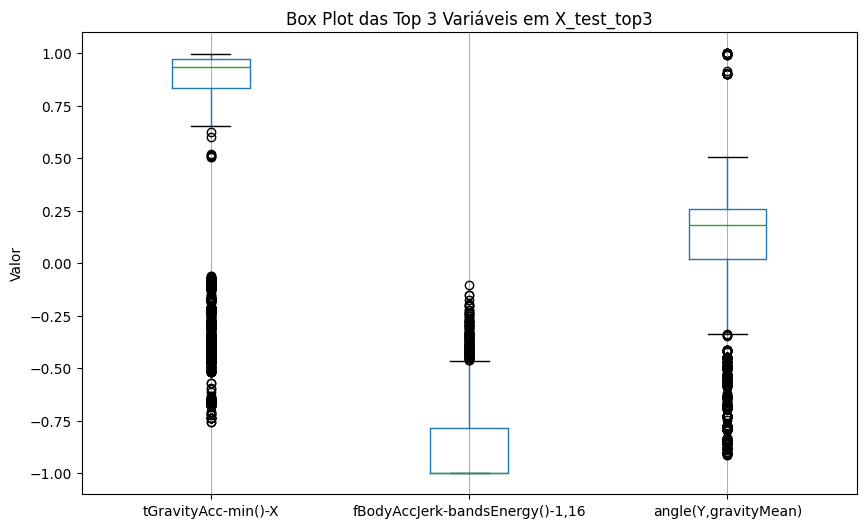

In [ ]:
# Plotting box plots for the top 3 features in X_test_top3
plt.figure(figsize=(10, 6))
X_test_top3.boxplot(column=X_test_top3.columns.tolist())
plt.title('Box Plot das Top 3 Variáveis em X_test_top3')
plt.ylabel('Valor')
plt.grid(axis='y')
plt.show()

In [ ]:
display(X_train_selected.describe())

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z
count,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141
std,0.070261,0.040811,0.056635
min,-1.000000,-1.000000,-1.000000
25%,0.262975,-0.024863,-0.120993
50%,0.277193,-0.017219,-0.108676
75%,0.288461,-0.010783,-0.097794
max,1.000000,1.000000,1.000000


In [276]:
# This cell is redundant as the evaluation with new features is done in cell da2949a3

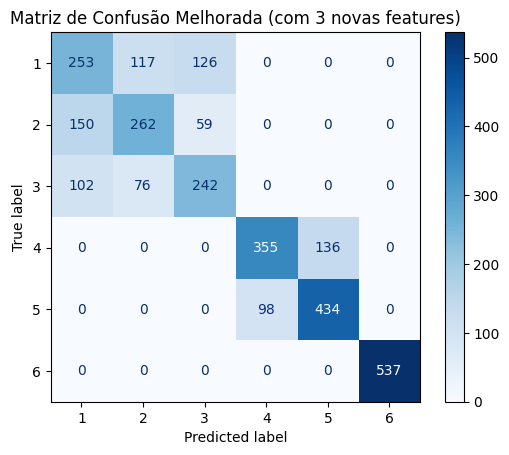

In [279]:
# Matriz de confusão melhorada
# Use ConfusionMatrixDisplay.from_predictions
disp_all = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_new_features, cmap=plt.cm.Blues)
disp_all.ax_.set_title("Matriz de Confusão Melhorada (com 3 novas features)")
plt.show()

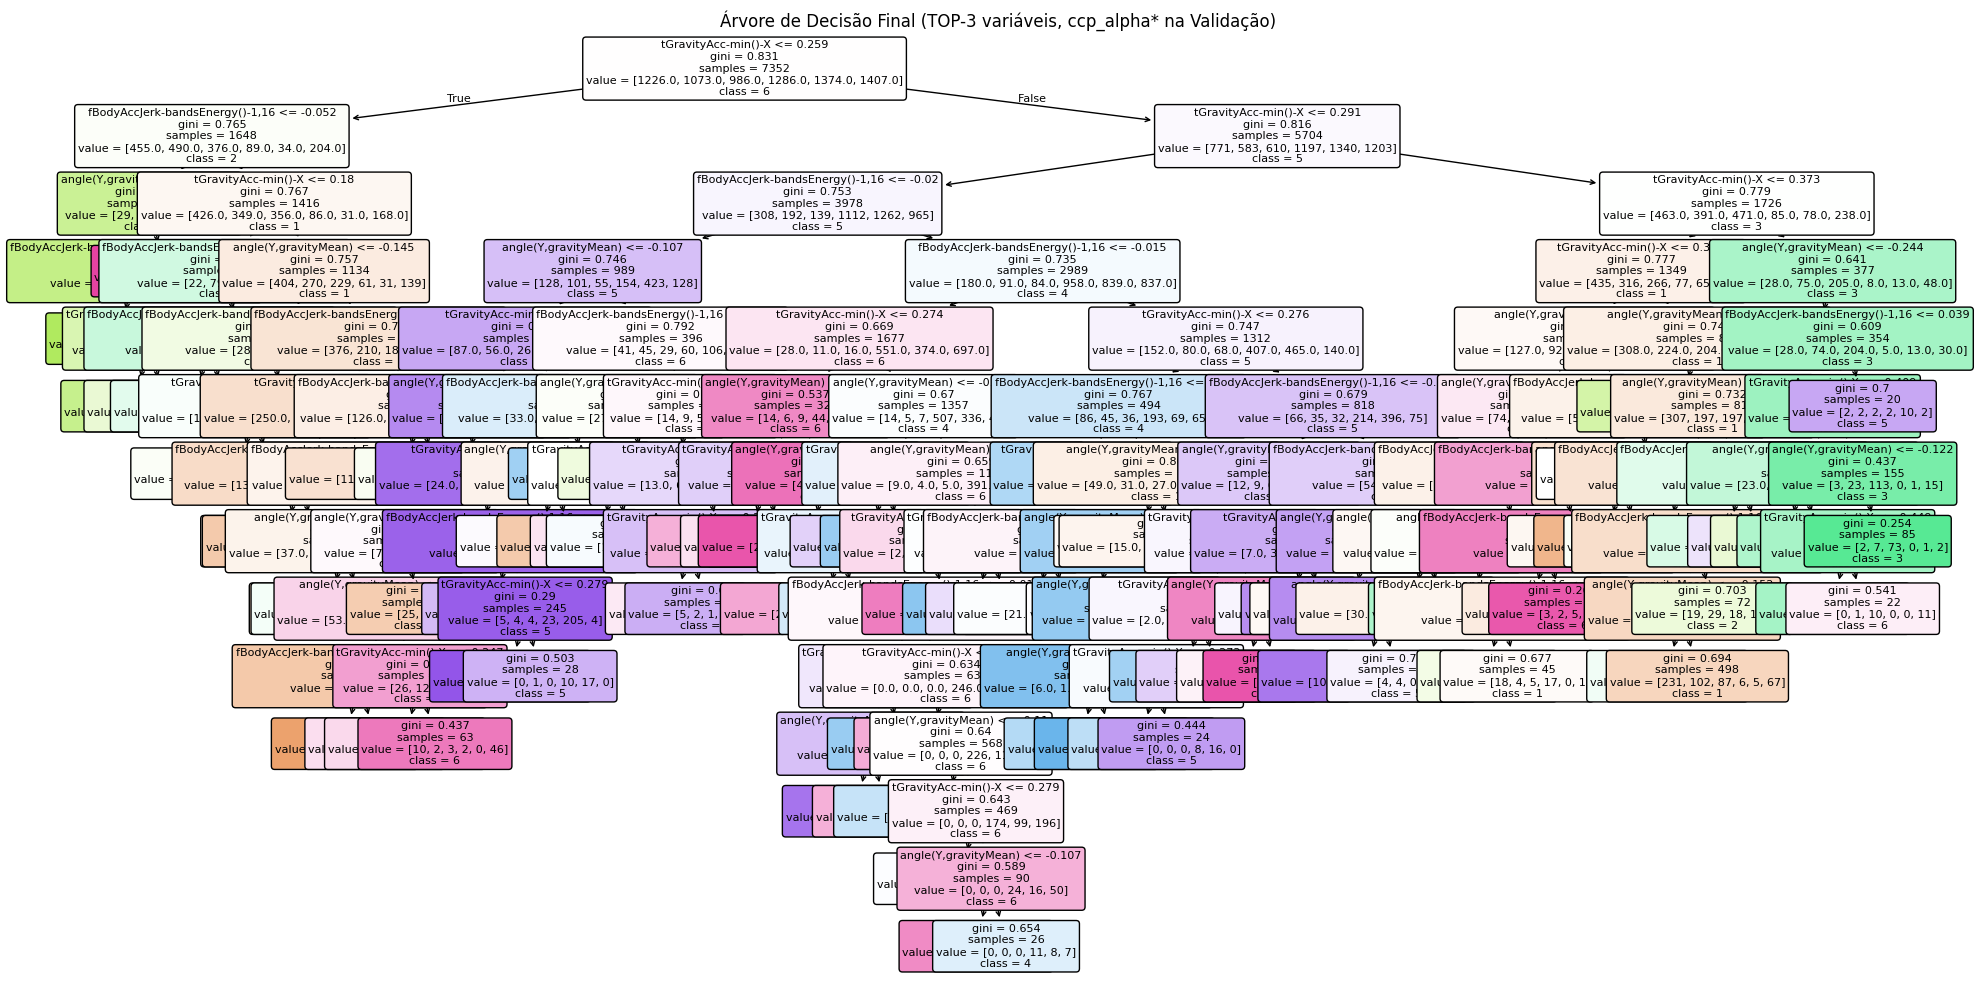

In [278]:
plt.figure(figsize=(20, 10))
plot_tree(
    best_clf,
    feature_names=top_3_features,
    class_names=[str(i) for i in range(1, 7)],
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title("Árvore de Decisão Final (TOP-3 variáveis, ccp_alpha* na Validação)")
plt.tight_layout()
plt.show()

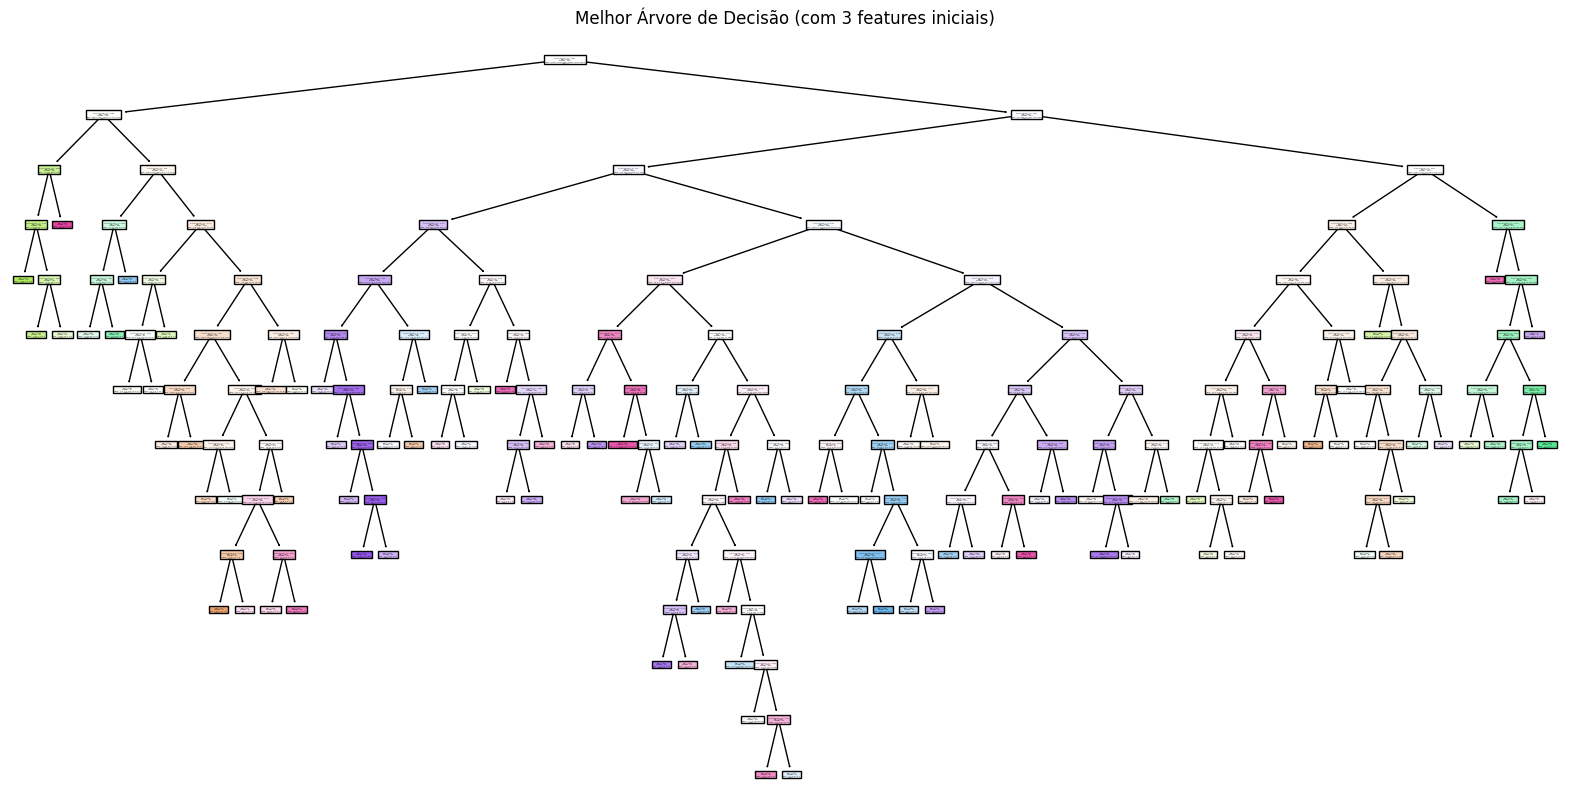

In [274]:
# 14. Visualizar a melhor árvore (opcional, para inspeção)
# Define selected_features if not already defined (using the initial 3 features)
selected_features = ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']

# Get class names from unique values in y_train, converted to string
class_names_str = [str(cls) for cls in np.unique(y_train)]


plt.figure(figsize=(20,10))
plot_tree(best_clf, feature_names=selected_features, class_names=class_names_str, filled=True)
plt.title("Melhor Árvore de Decisão (com 3 features iniciais)")
plt.show()

In [ ]:
print("Feature Importance Scores (all features):")
display(feature_importance_df)

Feature Importance Scores (all features):


,Feature,Importance
52,tGravityAcc-min()-X,0.286326
389,"fBodyAccJerk-bandsEnergy()-1,16",0.257330
559,"angle(Y,gravityMean)",0.162623
214,tGravityAccMag-std(),0.136890
74,"tGravityAcc-arCoeff()-Z,2",0.118864
...,...,...
192,"tBodyGyroJerk-arCoeff()-Y,4",0.000000
193,"tBodyGyroJerk-arCoeff()-Z,1",0.000000
194,"tBodyGyroJerk-arCoeff()-Z,2",0.000000
195,"tBodyGyroJerk-arCoeff()-Z,3",0.000000


**Conclusão**

A aplicação de árvores de decisão para classificar atividades humanas mostrou que a seleção de variáveis é determinante para o desempenho. Com três variáveis iniciais, o modelo atingiu 44% de acurácia, mas ao substituir pelas três features mais relevantes, o desempenho subiu para ≈70,7%.

Principais pontos:

 Seleção de Features: escolher variáveis informativas melhora drasticamente o modelo.

Poda (ccp_alpha): essencial para equilibrar simplicidade e generalização.

 Limitações: árvores simples são interpretáveis, mas limitadas — modelos como Random Forest ou Boosting podem extrair melhor o potencial dos dados.

 **Resumo:**

 A análise mostrou que uma escolha criteriosa de features e o controle adequado da complexidade são passos cruciais para aprimorar a classificação de atividades humanas.